In [1]:
import os
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
colors = sns.color_palette()

import joblib
from scipy import stats
import statsmodels.api as sm
SEED = 69

from utils import abcd, preprocess
ABCD_PATH = '../../ABCD'

In [2]:
fcon, fc_extra = abcd.load_data(ABCD_PATH, 'fcon', include_rec=True, exclude_n=True)
scon, sc_extra = abcd.load_data(ABCD_PATH, 'scon', include_rec=True)

subs = fcon.index.intersection(scon.index).get_level_values(0).unique()
print(len(subs), 'subjects')

fcon = fcon.loc[subs]
scon = scon.loc[subs]

3936 subjects


In [3]:
covariates = abcd.load_covariates('output/abcd_covariates.csv', simple_race=True)

# Preprocess

## Split replication sample

In [4]:
family = covariates.loc[idx[subs, abcd.EVENTS[1]], 'rel_family_id'].droplevel('eventname')

In [5]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=SEED)
disc, repl = next(gss.split(subs, groups=family))

In [6]:
fc, fc_repl = fcon.loc[subs[disc]], fcon.loc[subs[repl]]
sc, sc_repl = scon.loc[subs[disc]], scon.loc[subs[repl]]

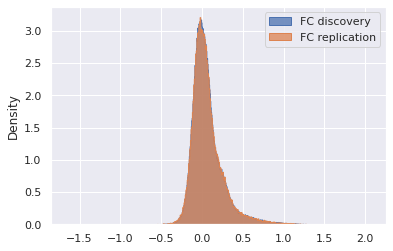

In [7]:
sns.histplot(fc.to_numpy().ravel(), label='FC discovery',
             stat='density', element='step', color=colors[0])
sns.histplot(fc_repl.to_numpy().ravel(), label='FC replication',
             stat='density', element='step', color=colors[1])
plt.legend()

plt.show()

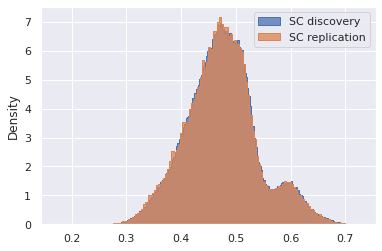

In [8]:
sns.histplot(sc.to_numpy().ravel(), label='SC discovery',
             stat='density', element='step', color=colors[0])
sns.histplot(sc_repl.to_numpy().ravel(), label='SC replication',
             stat='density', element='step', color=colors[1])
plt.legend()

plt.show()

## Remove outliers (MAD)

In [9]:
fc_mad = stats.median_abs_deviation(fc, nan_policy='omit')
fc_med = fc.median(axis=0)

sc_mad = stats.median_abs_deviation(sc, nan_policy='omit')
sc_med = sc.median(axis=0)

In [10]:
fc_noout = fc.mask((fc - fc_med).abs().divide(fc_mad) > 3)
fc_noout = fc_noout.loc[fc_noout.notna().sum(axis=1) > fc_noout.shape[1] * .8]
fc_noout = fc_noout.loc[:, fc_noout.notna().sum(axis=0) > fc_noout.shape[0] * .8]

In [11]:
sc_noout = sc.mask((sc - sc_med).abs().divide(sc_mad) > 3)
sc_noout = sc_noout.loc[sc_noout.notna().sum(axis=1) > sc_noout.shape[1] * .8]
sc_noout = sc_noout.loc[:, sc_noout.notna().sum(axis=0) > sc_noout.shape[0] * .8]

## Regress out confounds

In [12]:
fc_confounds = (covariates.loc[fcon.index, ['sex', 'race', 'site_id']]
                .join(fc_extra['rsfmri_c_ngd_meanmotion'].rename('meanmotion')))
sc_confounds = (covariates.loc[scon.index, ['sex', 'race', 'site_id']]
                .join(sc_extra['dmri_dti_meanmotion'].rename('meanmotion')))

In [13]:
# WARNING: LONG

# import warnings
# import statsmodels.api as sm
# import mapply
# mapply.init(n_workers=4, chunk_size=1, progressbar=True)

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
#     fc_noout_control = fc_noout.mapply(
#         preprocess.confound_residuals, model=sm.MixedLM,
#         regressors=fc_confounds.loc[fc_noout.index, ['sex', 'race', 'meanmotion']],
#         groups=fc_confounds.loc[fc_noout.index, 'site_id'],
#         method=['bfgs', 'cg', 'nm']
#     )
#     sc_noout_control = sc_noout.mapply(
#         preprocess.confound_residuals, model=sm.MixedLM,
#         regressors=sc_confounds.loc[sc_noout.index, ['sex', 'race', 'meanmotion']],
#         groups=sc_confounds.loc[sc_noout.index, 'site_id'],
#         method=['bfgs', 'cg', 'nm']
#     )

# fc_noout_control.to_pickle('.cache/fc_noout_control.pkl.gz')
# sc_noout_control.to_pickle('.cache/sc_noout_control.pkl.gz')
fc_noout_control = pd.read_pickle('.cache/fc_noout_control.pkl.gz')
sc_noout_control = pd.read_pickle('.cache/sc_noout_control.pkl.gz')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

## Input features

In [14]:
age = covariates.loc[fc_noout_control.index, 'interview_age'] / 12
age_diff = age.groupby(level=0).diff().dropna().droplevel('eventname')

dFC = (fc_noout_control.groupby(level=0)
       .diff().xs(abcd.EVENTS[1], level='eventname').loc[age_diff.index]
       .divide(age_diff, axis=0))

In [15]:
SC = sc_noout_control.loc[idx[dFC.index, abcd.EVENTS[0]], :].droplevel('eventname')
FC = fc_noout_control.loc[idx[SC.index, abcd.EVENTS[0]], :].droplevel('eventname')
X = FC.join(SC)

dFC = dFC.loc[X.index]
groups = family.loc[dFC.index]

## KNN Impute

In [16]:
from sklearn.impute import KNNImputer

In [17]:
imputer = KNNImputer(n_neighbors=3)

dFC = imputer.fit_transform(dFC)
SC = imputer.fit_transform(SC)
FC = imputer.fit_transform(FC)
X = imputer.fit_transform(X)

# Sparse CCA

In [18]:
from gemmr.estimators import SparseCCA
from sklearn.model_selection import GroupKFold

In [19]:
scca_SC = SparseCCA(n_components=10, scale=True, cv=GroupKFold(),
                    niter=200, verbose=True)

scca_SC.fit(SC, dFC, groups=groups)
joblib.dump(scca_SC, '.cache/scca_SC.joblib')

print('Score Correlations:', scca_SC.corrs_)

/home/kimsin98/miniconda3/envs/neuro/lib/python3.9/site-packages/gemmr/estimators/r_estimators.py:139: UserWarning: More than 1 mode selected: NOT TESTED
  warnings.warn('More than 1 mode selected: NOT TESTED')


[SparseCCA] penalties = [0. 1.]
Score Correlations: [0.14774373 0.14648403 0.12664582 0.1244605  0.13201853 0.1398192
 0.16546519 0.14412951 0.12962627 0.12934806]


In [20]:
scca_FC = SparseCCA(n_components=10, scale=True, cv=GroupKFold(),
                    niter=200, verbose=True)

scca_FC.fit(FC, dFC, groups=groups)
joblib.dump(scca_FC, '.cache/scca_FC.joblib')

print('Score Correlations:', scca_FC.corrs_)

/home/kimsin98/miniconda3/envs/neuro/lib/python3.9/site-packages/gemmr/estimators/r_estimators.py:139: UserWarning: More than 1 mode selected: NOT TESTED
  warnings.warn('More than 1 mode selected: NOT TESTED')


[SparseCCA] penalties = [0.2 0.2]
Score Correlations: [0.62620647 0.6083843  0.59560934 0.5578123  0.61448159 0.61802378
 0.6215872  0.54606619 0.57483706 0.62304469]


In [21]:
scca_X = SparseCCA(n_components=10, scale=True, cv=GroupKFold(),
                   niter=200, verbose=True)

scca_X.fit(X, dFC, groups=groups)
joblib.dump(scca_X, '.cache/scca_X.joblib')

print('Score Correlations:', scca_X.corrs_)

/home/kimsin98/miniconda3/envs/neuro/lib/python3.9/site-packages/gemmr/estimators/r_estimators.py:139: UserWarning: More than 1 mode selected: NOT TESTED
  warnings.warn('More than 1 mode selected: NOT TESTED')


[SparseCCA] penalties = [0.2 0.2]
Score Correlations: [0.61759173 0.59754503 0.59066383 0.55464491 0.60716904 0.60687563
 0.61343807 0.53644504 0.57550455 0.61425196]
